Загрузка датасета Rice (Cammeo and Osmancik)...
Размерность признаков (X): (3810, 7)
Размерность целевой переменной (y): (3810, 1)

Названия признаков: ['Area', 'Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length', 'Eccentricity', 'Convex_Area', 'Extent']
Классы: ['Cammeo' 'Osmancik']


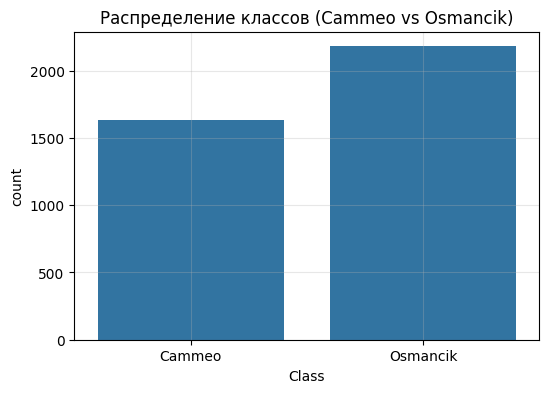


Размер train выборки: (3048, 7)
Размер test выборки: (762, 7)

--- Начало RBM Pre-training ---
1. Обучение RBM 1 (128 нейронов)...
   Epoch 0, Error: 0.0198
   Epoch 10, Error: 0.0148
   Epoch 20, Error: 0.0134
2. Обучение RBM 2 (64 нейрона)...
   Epoch 0, Error: 0.0003
   Epoch 10, Error: 0.0001
   Epoch 20, Error: 0.0001
3. Обучение RBM 3 (32 нейрона)...
   Epoch 0, Error: 0.0003
   Epoch 10, Error: 0.0001
   Epoch 20, Error: 0.0001

Обучение модели с RBM инициализацией...
Обучение базовой модели...

БАЗОВАЯ МОДЕЛЬ:
Accuracy: 0.9134
              precision    recall  f1-score   support

      Cammeo       0.92      0.88      0.90       326
    Osmancik       0.91      0.94      0.93       436

    accuracy                           0.91       762
   macro avg       0.91      0.91      0.91       762
weighted avg       0.91      0.91      0.91       762


МОДЕЛЬ С RBM:
Accuracy: 0.9068
              precision    recall  f1-score   support

      Cammeo       0.89      0.89      0.89 

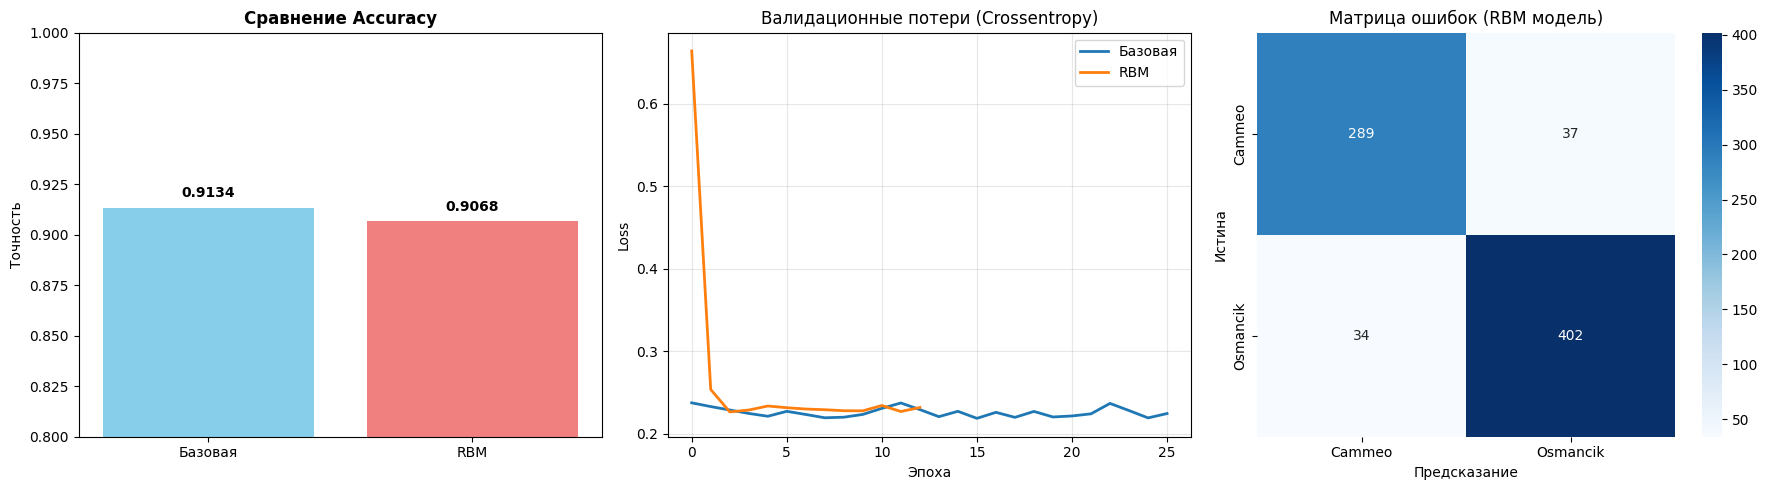

In [1]:
!pip install ucimlrepo
!pip install tensorflow
!pip install scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from ucimlrepo import fetch_ucirepo
import warnings

warnings.filterwarnings('ignore')

# --- 1. ЗАГРУЗКА ДАТАСЕТА (Rice Cammeo and Osmancik) ---
print("Загрузка датасета Rice (Cammeo and Osmancik)...")
rice_dataset = fetch_ucirepo(id=545)

X = rice_dataset.data.features
y = rice_dataset.data.targets

print(f"Размерность признаков (X): {X.shape}")
print(f"Размерность целевой переменной (y): {y.shape}")
print("\nНазвания признаков:", X.columns.tolist())
print("Классы:", y['Class'].unique())

# --- 2. ПРЕДОБРАБОТКА ---
# Кодирование целевой переменной (Cammeo -> 0, Osmancik -> 1)
le = LabelEncoder()
y_encoded = le.fit_transform(y['Class'])
class_names = le.classes_

# Заполнение пропусков (если есть)
if X.isnull().sum().sum() > 0:
    print("Заполняем пропущенные значения...")
    X = X.fillna(X.mean())

# Визуализация баланса классов
plt.figure(figsize=(6, 4))
sns.countplot(x=y['Class'])
plt.title('Распределение классов (Cammeo vs Osmancik)')
plt.grid(True, alpha=0.3)
plt.show()

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Масштабирование (StandardScaler)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

print(f"\nРазмер train выборки: {X_train_scaled.shape}")
print(f"Размер test выборки: {X_test_scaled.shape}")

# --- 3. КЛАСС RBM (Без изменений функционала) ---
class RBM:
    def __init__(self, n_visible, n_hidden, learning_rate=0.01, momentum=0.9):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.momentum = momentum

        self.W = np.random.normal(0, 0.01, (n_visible, n_hidden))
        self.v_bias = np.zeros(n_visible)
        self.h_bias = np.zeros(n_hidden)

        self.W_inc = np.zeros((n_visible, n_hidden))
        self.v_bias_inc = np.zeros(n_visible)
        self.h_bias_inc = np.zeros(n_hidden)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -250, 250)))

    def sample_hidden(self, visible):
        activation = np.dot(visible, self.W) + self.h_bias
        p_hidden = self.sigmoid(activation)
        return p_hidden, np.random.binomial(1, p_hidden)

    def sample_visible(self, hidden):
        activation = np.dot(hidden, self.W.T) + self.v_bias
        p_visible = self.sigmoid(activation)
        return p_visible, np.random.binomial(1, p_visible)

    def contrastive_divergence(self, input_data, k=1):
        pos_hidden_probs, pos_hidden_states = self.sample_hidden(input_data)
        hidden_states = pos_hidden_states
        for _ in range(k):
            neg_visible_probs, neg_visible_states = self.sample_visible(hidden_states)
            neg_hidden_probs, neg_hidden_states = self.sample_hidden(neg_visible_states)
            hidden_states = neg_hidden_states

        positive_associations = np.dot(input_data.T, pos_hidden_probs)
        negative_associations = np.dot(neg_visible_states.T, neg_hidden_probs)

        self.W_inc = self.momentum * self.W_inc + \
                    self.learning_rate * ((positive_associations - negative_associations) / len(input_data))
        self.v_bias_inc = self.momentum * self.v_bias_inc + \
                         self.learning_rate * np.mean(input_data - neg_visible_states, axis=0)
        self.h_bias_inc = self.momentum * self.h_bias_inc + \
                         self.learning_rate * np.mean(pos_hidden_probs - neg_hidden_probs, axis=0)

        self.W += self.W_inc
        self.v_bias += self.v_bias_inc
        self.h_bias += self.h_bias_inc

        reconstruction_error = np.mean((input_data - neg_visible_probs) ** 2)
        return reconstruction_error

    def transform(self, data):
        hidden_probs, _ = self.sample_hidden(data)
        return hidden_probs

    def get_weights(self):
        return [self.W, self.h_bias]

# --- 4. ПРЕДОБУЧЕНИЕ RBM ---
# Нормализация в 0-1 для RBM
X_min = X_train_scaled.min()
X_max = X_train_scaled.max()
X_train_rbm = (X_train_scaled - X_min) / (X_max - X_min)

input_dim = X_train_scaled.shape[1]
pretrained_weights_rbm = []

print("\n--- Начало RBM Pre-training ---")

print("1. Обучение RBM 1 (128 нейронов)...")
rbm1 = RBM(n_visible=input_dim, n_hidden=128)
rbm1_errors = []
for epoch in range(30):
    error = rbm1.contrastive_divergence(X_train_rbm)
    rbm1_errors.append(error)
    if epoch % 10 == 0: print(f"   Epoch {epoch}, Error: {error:.4f}")
pretrained_weights_rbm.append(rbm1.get_weights())
hidden1 = rbm1.transform(X_train_rbm)

print("2. Обучение RBM 2 (64 нейрона)...")
rbm2 = RBM(n_visible=128, n_hidden=64)
rbm2_errors = []
for epoch in range(30):
    error = rbm2.contrastive_divergence(hidden1)
    rbm2_errors.append(error)
    if epoch % 10 == 0: print(f"   Epoch {epoch}, Error: {error:.4f}")
pretrained_weights_rbm.append(rbm2.get_weights())
hidden2 = rbm2.transform(hidden1)

print("3. Обучение RBM 3 (32 нейрона)...")
rbm3 = RBM(n_visible=64, n_hidden=32)
rbm3_errors = []
for epoch in range(30):
    error = rbm3.contrastive_divergence(hidden2)
    rbm3_errors.append(error)
    if epoch % 10 == 0: print(f"   Epoch {epoch}, Error: {error:.4f}")
pretrained_weights_rbm.append(rbm3.get_weights())

# --- 5. СОЗДАНИЕ И ОБУЧЕНИЕ МОДЕЛЕЙ (CLASSIFICATION) ---

# Модель с RBM весами
pretrained_model = models.Sequential([
    layers.Dense(128, activation='sigmoid', input_shape=(input_dim,)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='sigmoid'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='sigmoid'),
    layers.Dropout(0.2),
    # Softmax для классификации (2 класса)
    layers.Dense(2, activation='softmax')
])

# Инициализация весами RBM
pretrained_model.layers[0].set_weights(pretrained_weights_rbm[0])
pretrained_model.layers[2].set_weights(pretrained_weights_rbm[1])
pretrained_model.layers[4].set_weights(pretrained_weights_rbm[2])

pretrained_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # Функция потерь для классификации
    metrics=['accuracy']
)

print("\nОбучение модели с RBM инициализацией...")
hist_rbm = pretrained_model.fit(
    X_train_scaled, y_train,
    epochs=60, batch_size=32, validation_split=0.2, verbose=0,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

# Базовая модель (случайные веса)
base_model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(input_dim,)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(2, activation='softmax')
])

base_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Обучение базовой модели...")
hist_base = base_model.fit(
    X_train_scaled, y_train,
    epochs=60, batch_size=32, validation_split=0.2, verbose=0,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

# --- 6. ОЦЕНКА И СРАВНЕНИЕ ---

def evaluate_classifier(model, X, y, name):
    loss, acc = model.evaluate(X, y, verbose=0)
    y_pred_prob = model.predict(X, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)

    print(f"\n{name}:")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y, y_pred, target_names=class_names))
    return acc, y_pred

acc_base, y_pred_base = evaluate_classifier(base_model, X_test_scaled, y_test, "БАЗОВАЯ МОДЕЛЬ")
acc_rbm, y_pred_rbm = evaluate_classifier(pretrained_model, X_test_scaled, y_test, "МОДЕЛЬ С RBM")

print(f"\nУлучшение Accuracy: {(acc_rbm - acc_base)*100:.2f}%")

# --- 7. ВИЗУАЛИЗАЦИЯ ---

plt.figure(figsize=(18, 5))

# 1. Сравнение Accuracy
plt.subplot(1, 3, 1)
plt.bar(['Базовая', 'RBM'], [acc_base, acc_rbm], color=['skyblue', 'lightcoral'])
plt.ylim(0.8, 1.0) # Масштаб для лучшей видимости разницы
plt.title('Сравнение Accuracy', fontweight='bold')
plt.ylabel('Точность')
for i, v in enumerate([acc_base, acc_rbm]):
    plt.text(i, v + 0.005, f"{v:.4f}", ha='center', fontweight='bold')

# 2. Кривые потерь
plt.subplot(1, 3, 2)
plt.plot(hist_base.history['val_loss'], label='Базовая', linewidth=2)
plt.plot(hist_rbm.history['val_loss'], label='RBM', linewidth=2)
plt.title('Валидационные потери (Crossentropy)')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Матрица ошибок (для RBM модели)
plt.subplot(1, 3, 3)
cm = confusion_matrix(y_test, y_pred_rbm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Матрица ошибок (RBM модель)')
plt.ylabel('Истина')
plt.xlabel('Предсказание')

plt.tight_layout()
plt.show()